In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers


# Read csv

In [2]:
#read the csv
#column Breed shows the y with the image name
data_csv = pd.read_csv('dataset_CV.csv')
data_csv.head()

DogId           Breed                                     Image  \
0   6673  SIBERIAN HUSKY  4d924d95-de4c-43c0-a586-9fb19cadf905.jpg   
1   6673  SIBERIAN HUSKY  851cc9ee-fc4d-430c-99f6-6425b8bbbe6b.jpg   
2   6673  SIBERIAN HUSKY  7d055dfa-dc6f-4f2b-a7be-dc8bc666836f.jpg   
3   6673  SIBERIAN HUSKY  f1f55f0a-c3d6-442b-b686-71b83b510dc5.jpg   
4   6671  SIBERIAN HUSKY  a2e49a61-7c6a-46f0-a80e-9f32e596c1df.jpg   

   ImageNumber  
0            1  
1            2  
2            3  
3            4  
4            1

In [3]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144 entries, 0 to 4143
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DogId        4144 non-null   int64 
 1   Breed        4144 non-null   object
 2   Image        4144 non-null   object
 3   ImageNumber  4144 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 129.6+ KB


# Preprocessing

In [4]:
data_dir = r"image_classes"

### Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4144 files belonging to 5 classes.
Using 3730 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4144 files belonging to 5 classes.
Using 414 files for validation.


In [8]:
split_ratio = 0.8
train_size = int(split_ratio * len(train_test_ds))
train_ds = train_test_ds.take(train_size)
test_ds = train_test_ds.skip(train_size)

In [9]:
class_names = val_ds.class_names
print(class_names)

['AMERICAN STAFFORDSHIRE BULL TERRIER', 'BORDER COLLIE', 'BULL ARAB', 'GERMAN SHEPHERD', 'SIBERIAN HUSKY']


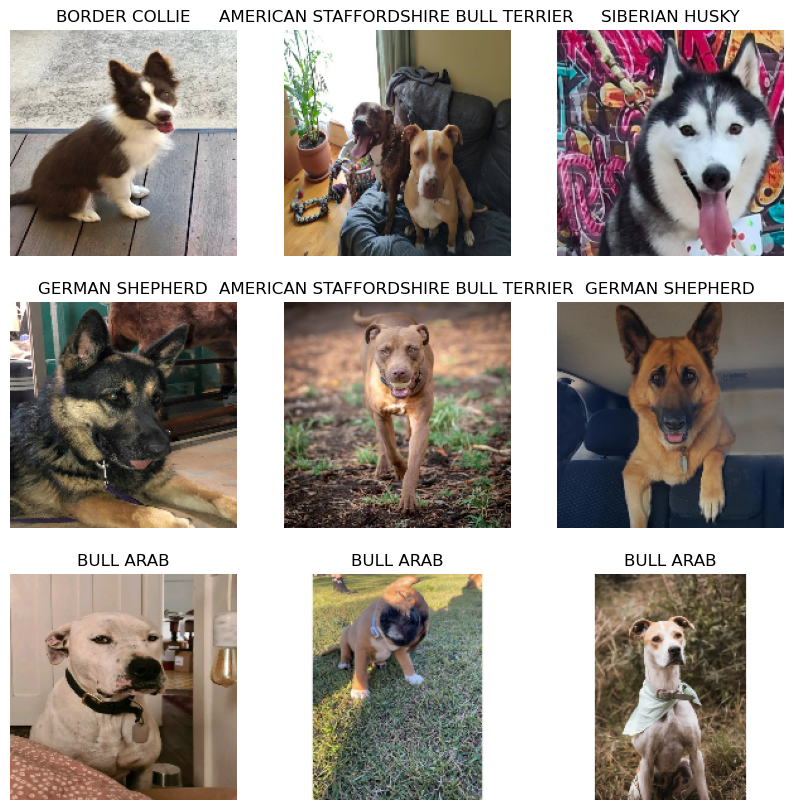

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

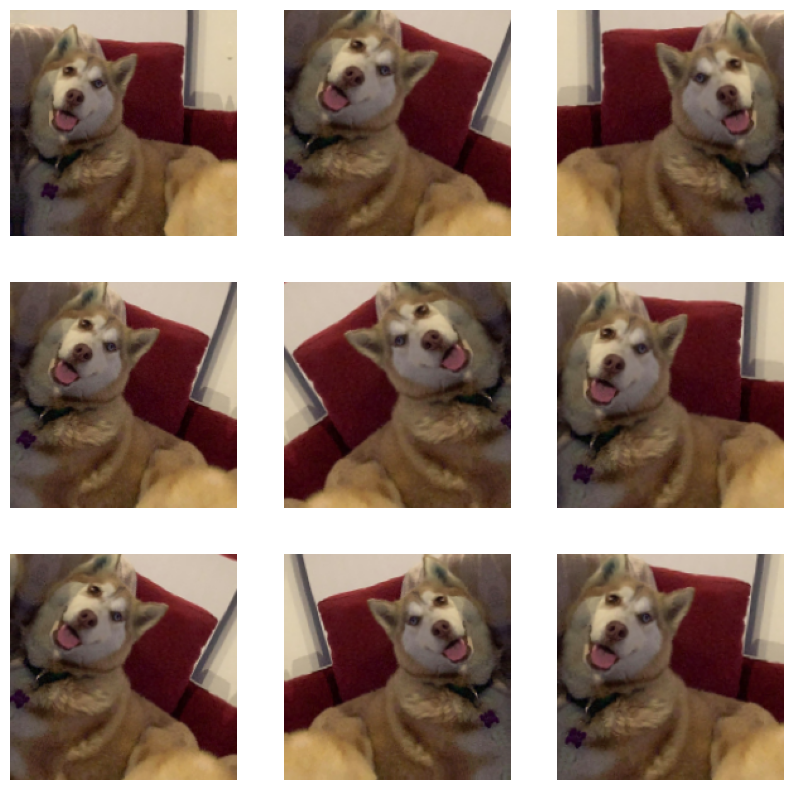

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Define cnn model

In [15]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Training

In [17]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
93/93 [==============================] - 46s 459ms/step - loss: 1.6991 - accuracy: 0.2372 - val_loss: 1.5204 - val_accuracy: 0.3599
Epoch 2/15
93/93 [==============================] - 40s 430ms/step - loss: 1.4847 - accuracy: 0.3579 - val_loss: 1.4281 - val_accuracy: 0.4275
Epoch 3/15
93/93 [==============================] - 38s 404ms/step - loss: 1.4207 - accuracy: 0.4046 - val_loss: 1.4928 - val_accuracy: 0.3889
Epoch 4/15
93/93 [==============================] - 34s 364ms/step - loss: 1.3841 - accuracy: 0.4234 - val_loss: 1.4234 - val_accuracy: 0.4106
Epoch 5/15
93/93 [==============================] - 38s 406ms/step - loss: 1.3355 - accuracy: 0.4546 - val_loss: 1.3441 - val_accuracy: 0.4710
Epoch 6/15
93/93 [==============================] - 44s 476ms/step - loss: 1.2613 - accuracy: 0.4829 - val_loss: 1.3389 - val_accuracy: 0.4783
Epoch 7/15
93/93 [==============================] - 47s 506ms/step - loss: 1.2274 - accuracy: 0.5111 - val_loss: 1.3891 - val_accuracy: 0.4614

# Plotting

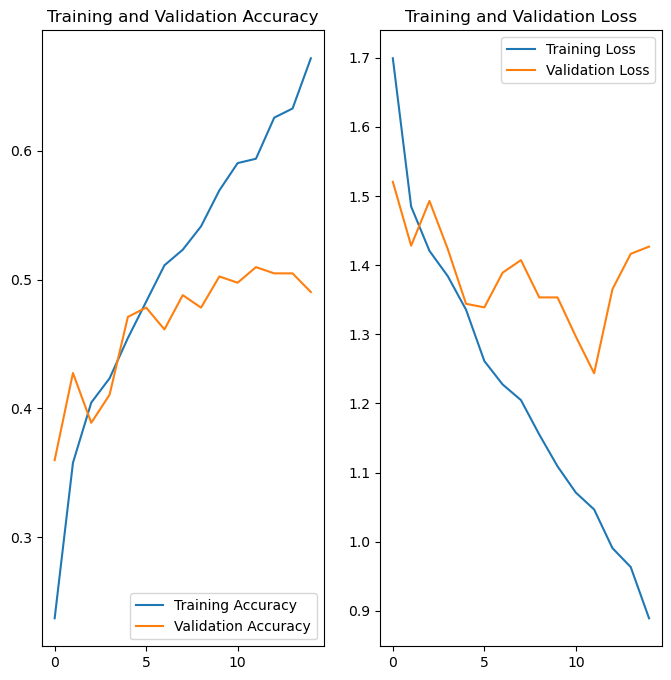

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluating

In [19]:
print(model.evaluate(test_ds))

24/24 [==============================] - 5s 89ms/step - loss: 1.2918 - accuracy: 0.5305
[1.291832447052002, 0.5305039882659912]


In [20]:
def plot_image(prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"), cmap=plt.cm.binary)
    predicted_label = class_names[np.argmax(prediction)]
    if predicted_label == class_names[true_label]:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                         100 * np.max(prediction),
                                         class_names[true_label]),
               color=color)

1/1 [==============================] - 0s 86ms/step


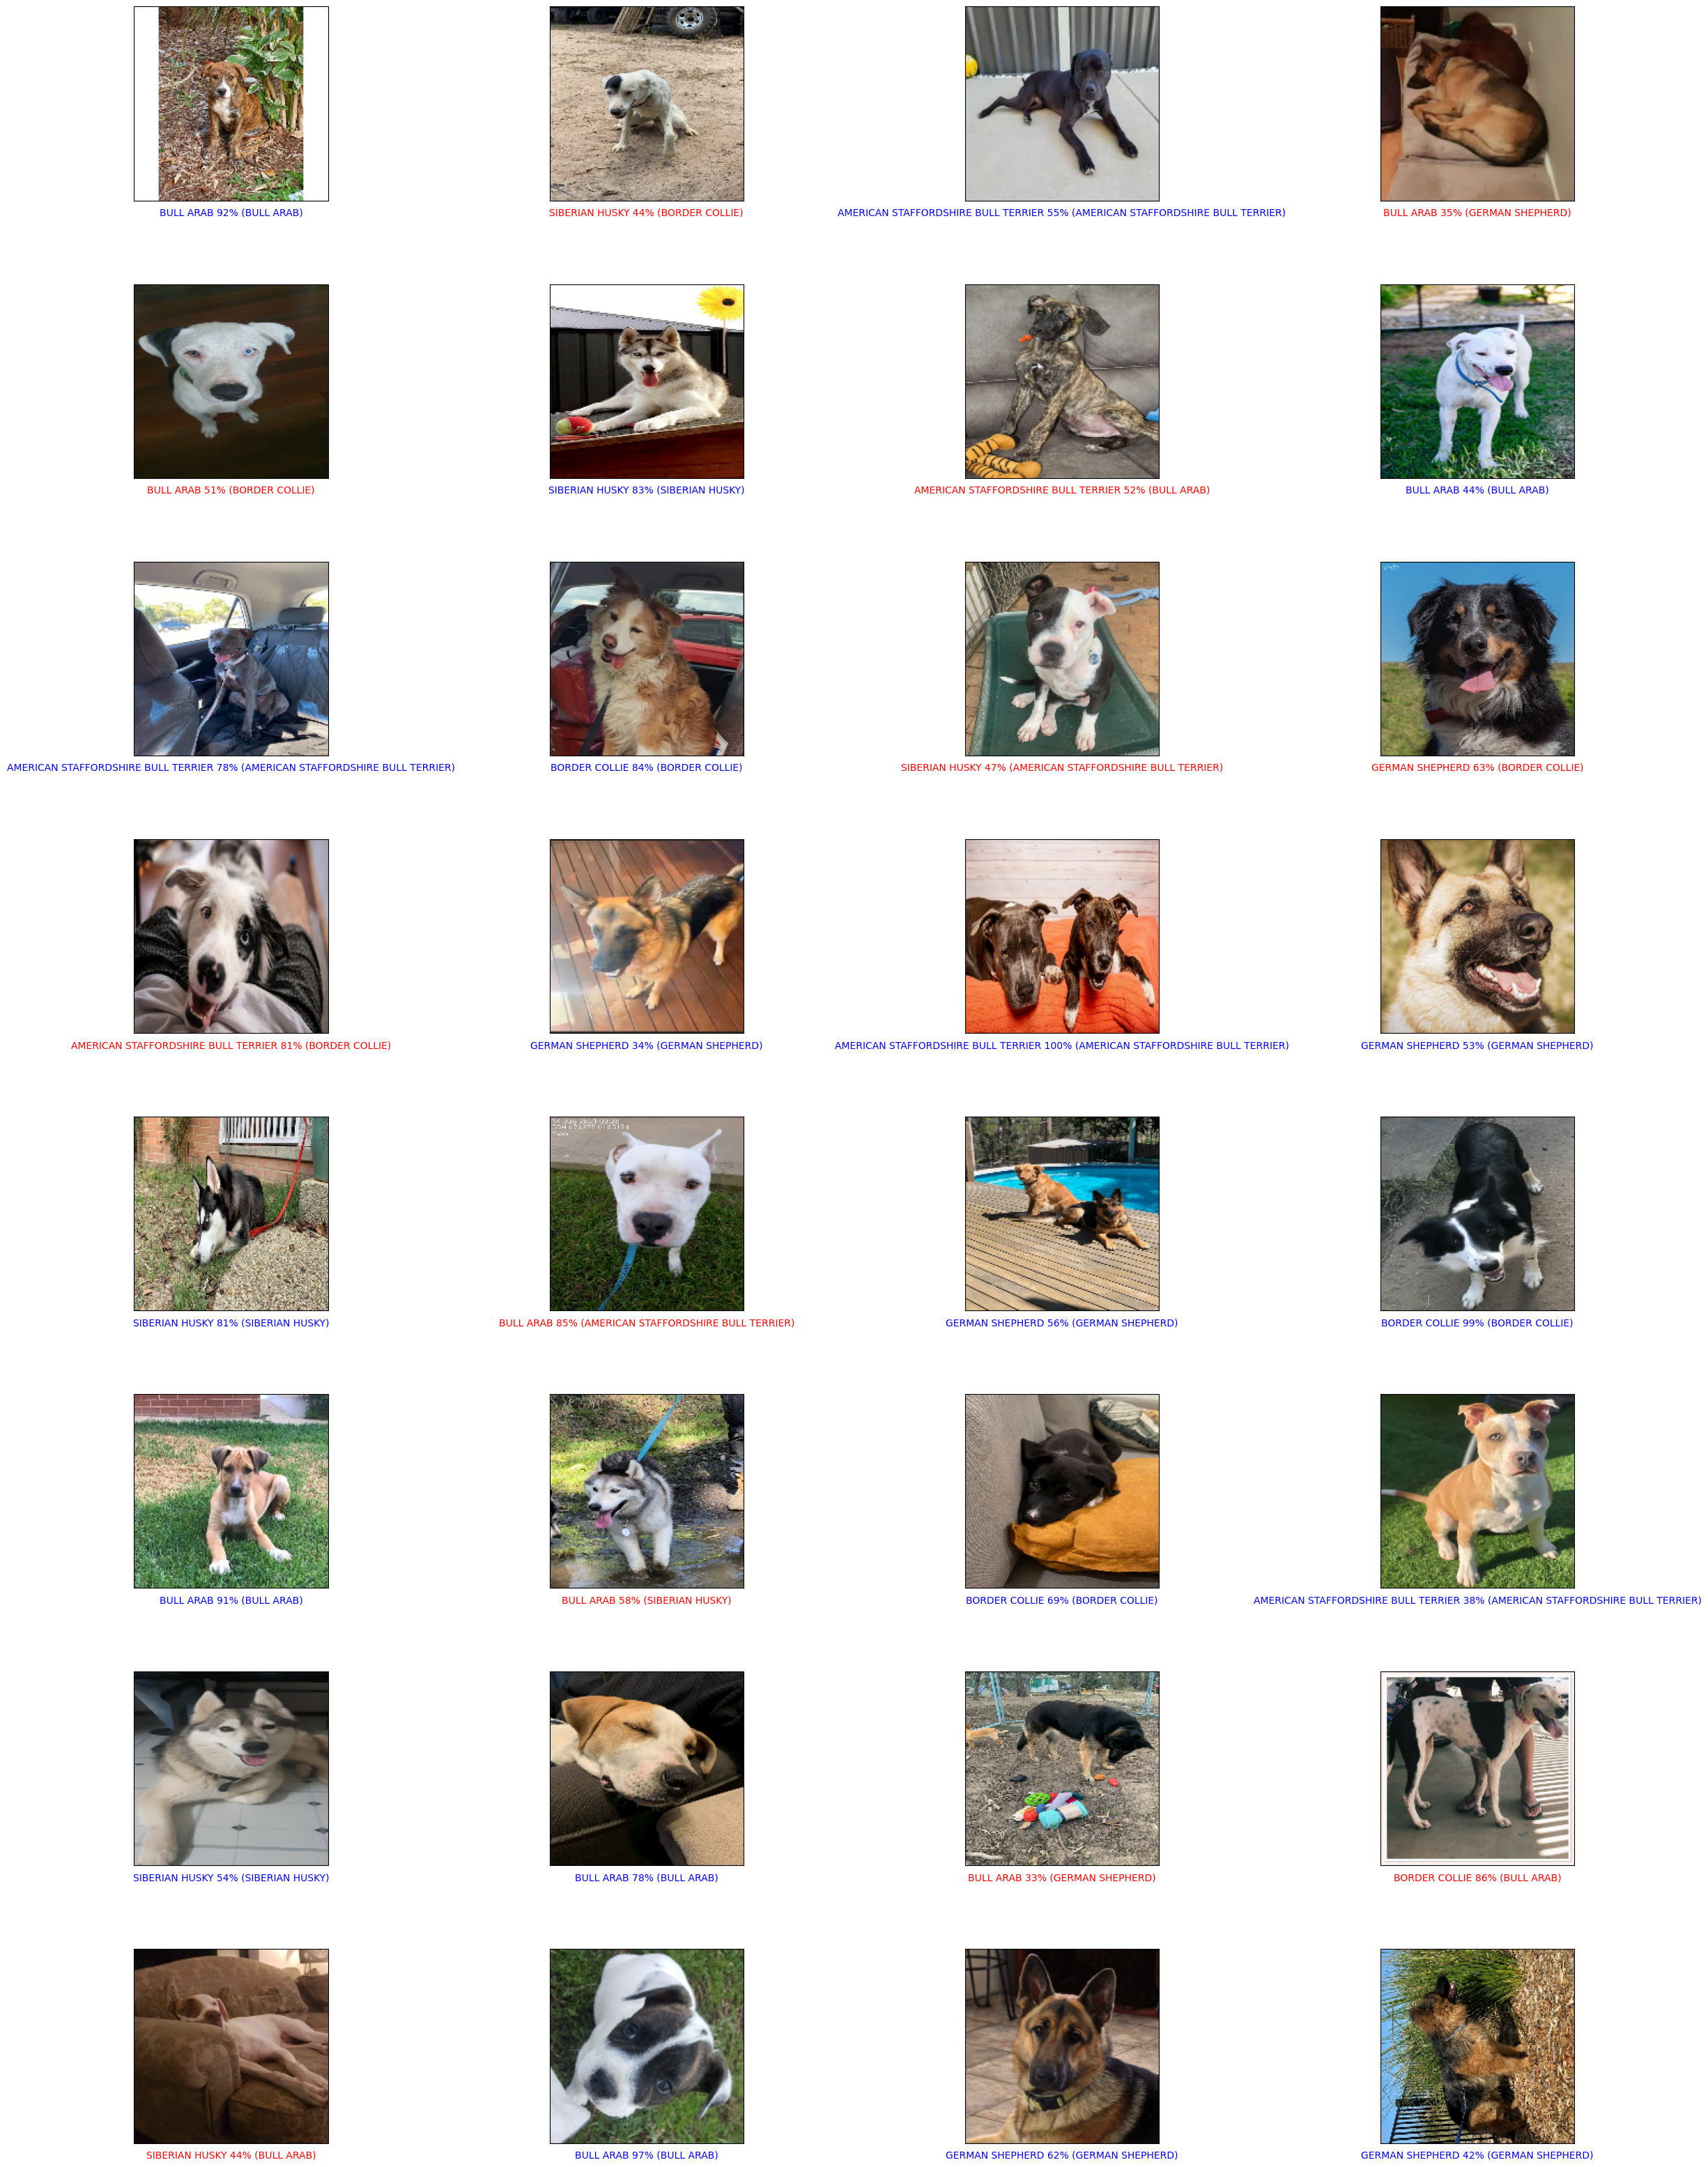

In [44]:
num_rows = 8
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

true_labels = []
test_predictions = []
for images, labels in test_ds.take(1):
    true_labels = labels
    predictions = model.predict(images)
    for i, prediction in enumerate(predictions):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(tf.nn.softmax(prediction), labels[i], images[i])
        test_predictions.append(np.argmax(tf.nn.softmax(prediction)))
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 63ms/step


<AxesSubplot:>

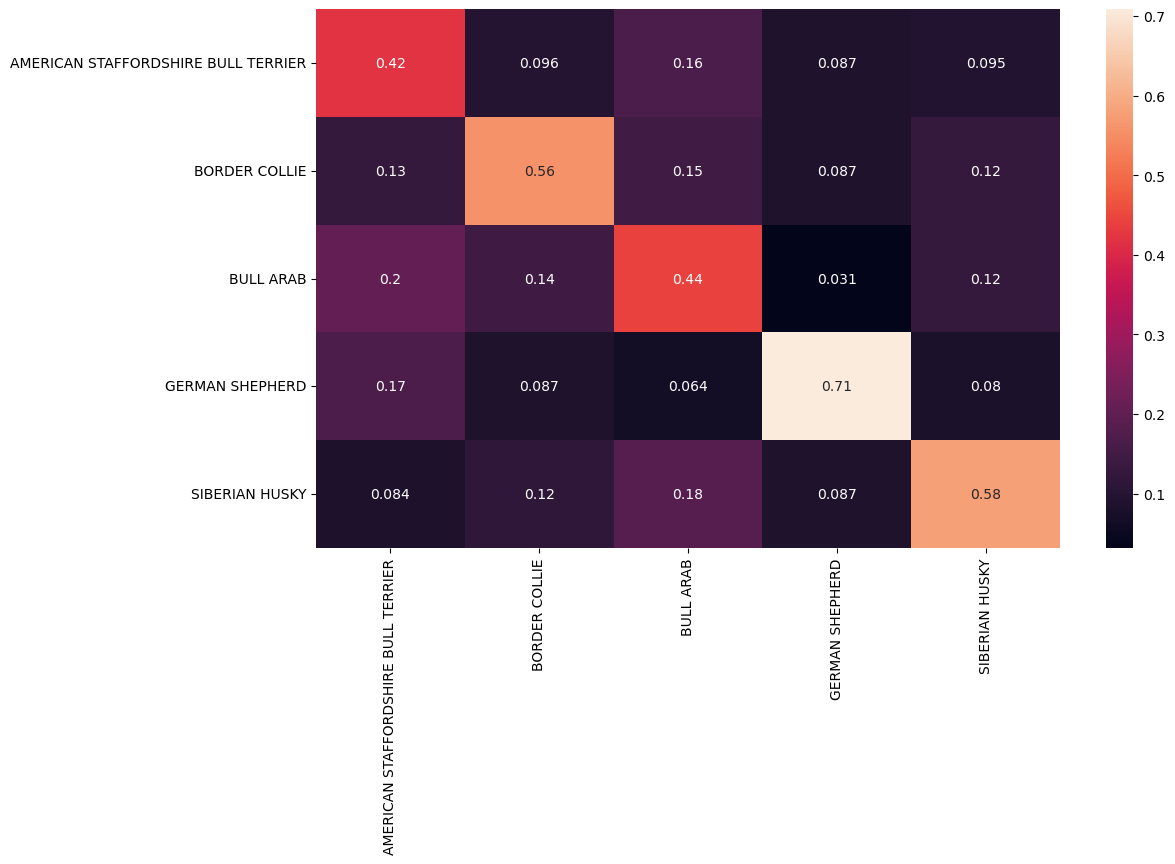

In [53]:
true_labels = []
test_predictions = []
for images, labels in test_ds:
    for label in labels:
        true_labels.append(label)
    predictions = model.predict(images)
    for i, prediction in enumerate(predictions):
        test_predictions.append(np.argmax(tf.nn.softmax(prediction)))

cf_matrix = confusion_matrix(true_labels, test_predictions)
df_cm = pd.DataFrame(cf_matrix.astype('float') / cf_matrix.astype('float').sum(axis=0), index=[i for i in class_names],
                     columns=[i for i in class_names])
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True)
#plt.savefig('output.png')